In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from yellowbrick.classifier import DiscriminationThreshold

#import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score

from sklearn.feature_selection import RFE
#from sklearn.feature_selection import chi2
#from sklearn.feature_selection import SelectKBest

init_notebook_mode(connected=True) 

import warnings
warnings.filterwarnings('ignore')

### 1. Business understanding
TELCO inc is a phoning company facing a churn problem. They collected a dataset on their past customers and ask to:
    - rank their customers according to the probability of churn
    - tell who are the clients they should contact and what should be the relevant personalized discount to propose in order to maximize the future profit of TELCO Inc (tradeoff between churn prevention and reduced profit per customer after discount). There is a fixed cost of 10€ to contacting a customer.

To conduct the presented project, I used CRISP-DM methodology; as presented in figure below. Put simply, it is a comprehensive data mining methodology and process model that helps on launching data mining projects. CRISP-DM breaks down the life cycle of a data mining project into six phases: business understanding, data understanding, data preparation, modeling, evaluation and deployment.


<img src="https://miro.medium.com/max/800/1*2NajmK58hJf8lJQm25iXWw.png">

### 2. Data understanding

In [3]:
#Reading provided data
df = pd.read_csv('training.csv')

#### 2.1. Data overview

In [4]:
df.head()

CUSTOMER_ID COLLEGE        DATA   INCOME  OVERCHARGE  LEFTOVER     HOUSE  \
0     C100000    zero  660.000000  19995.0           0         0  897338.0   
1     C100001     one  317.647059  31477.0         155        15  393396.0   
2     C100006    zero  208.695652  66742.0           0        13  937197.0   
3     C100008    zero  265.017668  40864.0         183         0  986430.0   
4     C100010     one  440.000000  43321.5         200         0  394622.0   

  LESSTHAN600k  CHILD  JOB_CLASS  REVENUE  HANDSET_PRICE  \
0        False      4          3    160.0            155   
1         True      0          1    100.0            245   
2        False      4          2    127.0            493   
3        False      3          3     86.0            390   
4         True      2          3     77.0            175   

   OVER_15MINS_CALLS_PER_MONTH  TIME_CLIENT  AVERAGE_CALL_DURATION  \
0                            1          1.2                     15   
1                           27          2.7                      4   
2                           20          2.6                      4   
3                           13          2.5                     12   
4                           18          2.4                     10   

  REPORTED_SATISFACTION REPORTED_USAGE_LEVEL CONSIDERING_CHANGE_OF_PLAN  \
0            very_unsat               little                considering   
1                 unsat               little                considering   
2                   avg          very_little                considering   
3                 unsat            very_high                considering   
4            very_unsat               little   actively_looking_into_it   

  CHURNED  
0    STAY  
1   LEAVE  
2    STAY  
3   LEAVE  
4   LEAVE

In [5]:
print ("\nMissing values :  \n", df.isnull().sum())
print ("\nUnique values :  \n", df.nunique())


Missing values :  
 CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          635
LESSTHAN600k                   635
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
CHURNED                          0
dtype: int64

Unique values :  
 CUSTOMER_ID                    11981
COLLEGE                            2
DATA                            6639
INCOME                         10629
OVERCHARGE                       263
LEFTOVER                          86
HOUSE                          10386
LESSTHAN600k          

Attributes HOUSE and LESSTHAN600k contain each 625 missing values. I will deal with this in the next section.

There is no unique value column.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 19 columns):
CUSTOMER_ID                    11981 non-null object
COLLEGE                        11981 non-null object
DATA                           11981 non-null float64
INCOME                         11981 non-null float64
OVERCHARGE                     11981 non-null int64
LEFTOVER                       11981 non-null int64
HOUSE                          11346 non-null float64
LESSTHAN600k                   11346 non-null object
CHILD                          11981 non-null int64
JOB_CLASS                      11981 non-null int64
REVENUE                        11981 non-null float64
HANDSET_PRICE                  11981 non-null int64
OVER_15MINS_CALLS_PER_MONTH    11981 non-null int64
TIME_CLIENT                    11981 non-null float64
AVERAGE_CALL_DURATION          11981 non-null int64
REPORTED_SATISFACTION          11981 non-null object
REPORTED_USAGE_LEVEL           11981 non-null

As we can see, in the training dataset, there are 12 numerical columns and 7 categorical columns 

#### 2.2. Basic data preprocessing for Exploratory Data Analysis

In [7]:
#Replacing missing values with null values in HOUSE and LESSTHAN600k columns
df['HOUSE'] = df['HOUSE'].fillna(np.nan)
df['LESSTHAN600k'] = df['LESSTHAN600k'].fillna(np.nan)

#Dropping null values from HOUSE and LESSTHAN600k columns which contain 5% missing data
#Listwise deletion / Data cleaning
df = df[df['HOUSE'].notnull()]
df = df[df['LESSTHAN600k'].notnull()]

Dropping missing values is not the cleanest way to deal with this problem. But, in this use case with the provided contexte and data, I cannot understand the reason why data goes missing. 
This assumption can produce a bias in the model if the missing data are not at Random (MNAR).

In [8]:
#Separating churn and non churn customers
churn     = df[df["CHURNED"] == "LEAVE"]
not_churn = df[df["CHURNED"] == "STAY"]

#Separating catagorical and numerical columns
#constumer id column
Id_col     = ['CUSTOMER_ID']
#target column
target_col = ["CHURNED"]

#categorical columns
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

#Apparently in column OVERCHARGE row 8698 the value is 0.0 but pandas see it like a negative value
#I performed a single unitary test: df_og.index[df_og['OVERCHARGE'] < 0]
df['OVERCHARGE'] = df['OVERCHARGE'].abs()

#### 2.3. Churn Ratio

In [9]:
trace = go.Pie(values=churn, labels=churn.index.tolist(), hole=.3)

trace = go.Pie(labels = df["CHURNED"].value_counts().keys().tolist(),
               values = df["CHURNED"].value_counts().values.tolist(),
               marker = dict(colors =  [ 'gold' ,'darkorange'],
                             line = dict(color = "white",
                                         width =  3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = 0
              )
layout = go.Layout(dict(title = "Customer attrition in TELCO data"
                       ),
                   height=500, width=700
                  )

data = [trace]
fig = go.Figure(data = data,layout = layout)
fig.show()

In the training dataset 36.5% of costumers left. So, we are facing an Unbalanced classes problem.
Handling this issue sometimes could be complicated. Later, I will perform a technic to handle this problem.

#### 2.4. Varibles distribution in customer attrition

In [10]:
#function  for pie plot for customer attrition types
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name+value",
                    domain  = dict(x = [0,.48]),
                    name    = "Leave",
                    marker  = dict(colors=['gold', 'mediumturquoise', 'darkorange', 'plum'],
                                   line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .4
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name+value",
                    marker  = dict(colors=['gold', 'mediumturquoise', 'darkorange', 'plum'],
                                   line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    name    = "Stay",
                    hole    = .4 
                   )

    layout = go.Layout(dict(title = column + " distribution in customer attrition ",
                            annotations = [dict(text = "Leave",
                                                font = dict(size = 17),
                                                showarrow = False,
                                                x = .20, y = .5),
                                           dict(text = "Stay",
                                                font = dict(size = 17),
                                                showarrow = False,
                                                x = .79,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    fig.show()

    
    
#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Leave",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Stay",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         ) 
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    fig.show()
    
    

#function  for scatter plot matrix  for numerical columns in data
def scatter_matrix(df):
    
    df  = df.sort_values(by = "CHURNED" ,ascending = True)
    classes = df["CHURNED"].unique().tolist()
    classes
    
    class_code  = {classes[k] : k for k in range(2)}
    class_code

    color_vals = [class_code[cl] for cl in df["CHURNED"]]
    color_vals

    pl_colorscale = "Portland"

    pl_colorscale

    #text = [df.loc[k,"CHURNED"] for k in range(len(df))]
    #text

    trace = go.Splom(dimensions = [dict(label  = "DATA",
                                       values = df["DATA"]),
                                  dict(label  = 'REVENUE',
                                       values = df['REVENUE']),
                                  dict(label  = 'TIME_CLIENT',
                                       values = df['TIME_CLIENT'])],
                     
                     marker = dict(color = color_vals,
                                   colorscale = pl_colorscale,
                                   size = 3,
                                   showscale = False,
                                   line = dict(width = .1,
                                               color='rgb(230,230,230)'
                                              )
                                  )
                    )
    axis = dict(showline  = True,
                zeroline  = False,
                gridcolor = "#fff",
                ticklen   = 4
               )
    
    layout = go.Layout(dict(title  = 
                            "Scatter plot matrix for Numerical columns for customer attrition",
                            autosize = False,
                            height = 800,
                            width  = 800,
                            dragmode = "select",
                            hovermode = "closest",
                            plot_bgcolor  = 'rgba(240,240,240, 0.95)',
                            xaxis1 = dict(axis),
                            yaxis1 = dict(axis),
                            xaxis2 = dict(axis),
                            yaxis2 = dict(axis),
                            xaxis3 = dict(axis),
                            yaxis3 = dict(axis),                         
                           )
                      )
    data   = [trace]
    fig = go.Figure(data = data,layout = layout )
    fig.show()

In [11]:
#for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i)

- The distribution of College is the same in customer attrition
- 78% of customers who left have a less than 600k house
- The distribution of Job_Class is the same in customer attrition
- 55% of customers who left were very_unsat and 8.5% of them were very_sat.
- The distribution of REPORTED_USAGE_LEVEL is the same
- 75.6% of customers who left were considering and actively looking into changing of plan


We will see later, why features analysis and engineering matter a lot.

"Coming up with features is difficult, time consuming, requires expert knowledge. Applied machine learning is basically feature engineering." ~ Andrew Ng

In [11]:
#for all numerical columns plot histogram    
for i in num_cols :
    histogram(i)

We can get some insights from these histograms. As I can see, some observation points are distant from other observations (outliers). For the sake of simplicity, I will proceed to a simple checking test for some features by using a scatter plot matrix (we can also discover outliers with other visualization tools like boxplots, Z-score...).

In [12]:
#scatter plot matrix
scatter_matrix(df)

Looking at the plots above, we cans see that most of data points are lying bottom left side but there are points which are far from the population like top right corner...

Now, as I have detected some outliers one of most difficult decision could be how one should deal with the outliers. Remove them or correct them? As I said before for the sake of simplicity I will not deal with them (So this dataset consist of a level of noise. Models' performances ?).

#### 2.5. Attributes summary

In [13]:
summary = (df[[i for i in df.columns if i not in Id_col]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#F09D00']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [500,80,80,80,80,80,80,80,80])
layout = go.Layout(dict(title = "Variable Summary"))
fig = go.Figure(data=[trace],layout=layout)
fig.show()

### 3. Data preprocessing

In [14]:
#As I have already preprocessed some data for exploratory data analysis (previous plots). I will make 
#some data preprocessing manipulations to make this dataset ready for modeling

#Separating catagorical and numerical columns
#constumer id column
Id_col     = ['CUSTOMER_ID']
#target column
target_col = ["CHURNED"]
#categorical columns
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols )

#Copying original table beforing standarisation
df_og = df.copy()

#Scaling Numerical columns
std = StandardScaler()
df[num_cols] = std.fit_transform(df[num_cols])

#### 2.6. Correlation matrix

In [15]:
#correlation
correlation = df.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
fig.show()

The matrix above visulises the correlation matrix of all features. High positive correlation are shown in yellow, high negative correlations in blue.


The majority of features are only weakly correlated.


The only high correlated features are HOUSE and LESSTHAN600K. It certainly makes sense to reduce one of them as they are very unlikely to contribute any further information and are very likely to cause overfitting.

In [16]:
#Drop LESSTHAN600K
df = df.drop(labels=['LESSTHAN600k'], axis=1)

### 4. Modeling

#### 4.1. Modeling help functions

In [17]:
#splitting train and test data 
train,test = train_test_split(df,test_size = .25 ,random_state = 111)
    
##seperating dependent and independent variables
cols    = [i for i in df.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]
  
def churn_prediction(algorithm,training_x,testing_x,
                     training_y,testing_y,cols,cf,threshold_plot) :
    
    #Function attributes:
        #Algorithm     - Algorithm used 
        #training_x    - predictor variables dataframe(training)
        #testing_x     - predictor variables dataframe(testing)
        #training_y    - target variable(training)
        #training_y    - target variable(testing)
        #cf - ["coefficients","features"](cooefficients for logistic 
                                 #regression,features for tree based models)
        #threshold_plot - if True returns threshold plot for model 
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    predictions_train   = algorithm.predict(training_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions)
    model_roc_auc_train = roc_auc_score(training_y,predictions_train)
    print("Area under curve - train : ", model_roc_auc_train)
    print("Area under curve - test : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1]) 
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    layout = go.Layout(dict(title = "Features Importance"
                       ),
                   height=800, width=850
                  )
    
    data = [trace4]
    fig = go.Figure(data=data,layout=layout)
    fig.show()
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        
        
def churn_prediction_(algorithm,training_x,testing_x,
                      training_y,testing_y,threshold_plot = True):
    
    #model
    algorithm.fit(training_x,training_y)
    predictions   = algorithm.predict(testing_x)
    predictions_train   = algorithm.predict(training_x)
    probabilities = algorithm.predict_proba(testing_x)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy Score   : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions)
    model_roc_auc_train = roc_auc_score(training_y,predictions_train)
    print("Area under curve - train : ", model_roc_auc_train)
    print("Area under curve - test : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

#### 4.2. Baseline Model - Logistic regression

In [18]:
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

churn_prediction(logit,train_X,test_X,train_Y,test_Y, cols,"coefficients",threshold_plot = False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.66      0.51      0.57      1062
           1       0.74      0.84      0.79      1775

    accuracy                           0.72      2837
   macro avg       0.70      0.67      0.68      2837
weighted avg       0.71      0.72      0.71      2837

Accuracy   Score :  0.7166020444131125
Area under curve - train :  0.6805049246315747
Area under curve - test :  0.6746115487652848 



#### 4.3. Synthetic Minority Oversampling Technic (SMOTE)

    - Randomly pick a point from the minority class
    - Compute the k-nearest neighbors (for some pre-specified k) for this point
    - Add k new points somewhere between the chosen point and each of its neighbors

In [19]:
cols    = [i for i in df.columns if i not in Id_col+target_col]

smote_X = df[cols]
smote_Y = df[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)


logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

churn_prediction(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.58      0.70      0.64      1062
           1       0.80      0.70      0.74      1775

    accuracy                           0.70      2837
   macro avg       0.69      0.70      0.69      2837
weighted avg       0.72      0.70      0.70      2837

Accuracy   Score :  0.7000352485019387
Area under curve - train :  0.7141540729819388
Area under curve - test :  0.7001416408052837 



#### 4.4. Recursive Feature Elimination
    Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [20]:
logit = LogisticRegression()

rfe = RFE(logit,10)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in df.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,
                      })
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#separating train and test data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
churn_prediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = False)

tab_rk = ff.create_table(idc_rfe)
tab_rk.show()

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.57      0.71      0.63      1062
           1       0.80      0.68      0.73      1775

    accuracy                           0.69      2837
   macro avg       0.68      0.70      0.68      2837
weighted avg       0.71      0.69      0.70      2837

Accuracy   Score :  0.6915756080366584
Area under curve - train :  0.7006081828234426
Area under curve - test :  0.6954613935969869 



This result was expected. This dataset is not rich enough so attribute removal will make it poorer.

#### 4.5. Gaussian Naive Bayes

GaussianNB(priors=None, var_smoothing=1e-09)

 Classification report : 
               precision    recall  f1-score   support

           0       0.50      0.66      0.57      1062
           1       0.75      0.61      0.67      1775

    accuracy                           0.63      2837
   macro avg       0.62      0.63      0.62      2837
weighted avg       0.66      0.63      0.63      2837

Accuracy Score   :  0.6270708494888967
Area under curve - train :  0.6591411721341687
Area under curve - test :  0.632943158006419 



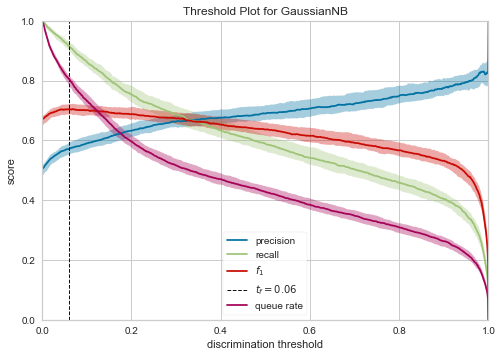

In [21]:
gnb = GaussianNB(priors=None)

churn_prediction_(gnb,os_smote_X,test_X,os_smote_Y,test_Y)

A naive Bayes classifier assumes that the presence (or absence) of a particular feature of a class is unrelated to the presence (or absence) of any other feature, given the class variable. ~ Naive Assumption. I was not expecting a better performance.

#### 4.6. Support Vector Machine

In this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes

In [22]:
#Support vector classifier
#using linear hyper plane
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

cols = [i for i in df.columns if i not in Id_col + target_col]
churn_prediction(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = False)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.58      0.71      0.64      1062
           1       0.80      0.69      0.74      1775

    accuracy                           0.70      2837
   macro avg       0.69      0.70      0.69      2837
weighted avg       0.72      0.70      0.70      2837

Accuracy   Score :  0.699682763482552
Area under curve - train :  0.71516771102101
Area under curve - test :  0.7019402668364234 



#### 4.7. Light GBM Classifier

In [23]:
lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.01, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

cols = [i for i in df.columns if i not in Id_col + target_col]
churn_prediction(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = False)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=500, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 Classification report : 
               precision    recall  f1-score   support

           0       0.65      0.73      0.69      1062
           1       0.82      0.77      0.80      1775

    accuracy                           0.75      2837
   macro avg       0.74      0.75      0.74      2837
weighted avg       0.76      0.75      0.76      2837

Accuracy   Score :  0.7536129714487134
Area under curve - train :  0.8166236638407667
Area under curve - test :  0.7480647728176972 



#### 4.8. XGBoost Classifier

In [24]:
xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=200,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)

churn_prediction(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

 Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.70      0.71      1062
           1       0.83      0.84      0.83      1775

    accuracy                           0.79      2837
   macro avg       0.78      0.77      0.77      2837
weighted avg       0.79      0.79      0.79      2837

Accuracy   Score :  0.7902714134649277
Area under curve - train :  0.9109841503870255
Area under curve - test :  0.7726325561656189 



### 5. Evaluation

#### 5.1. model performance metrics

In [25]:
#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)

    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Area_under_curve": [roc_auc],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Logistic Regression(Baseline_model)")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Logistic Regression(SMOTE)")
model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "Logistic Regression(RFE)")
model4 = model_report(gnb,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Naive Bayes")
model5 = model_report(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier Linear")
model7 = model_report(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LGBM Classifier")
model8 = model_report(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "XGBoost Classifier")

#concat all models
model_performances = pd.concat([model1,model2,model3,
                                model4,model5,model7,
                                model8,],
                               axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

table.show()

#### 5.2. Metrics comparison

In [26]:
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )

trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Area_under_curve',"lightgrey")

data = [trace1,trace2]
fig = go.Figure(data=data,layout=layout)
fig.show()

#### 5.3. Confusion matrics

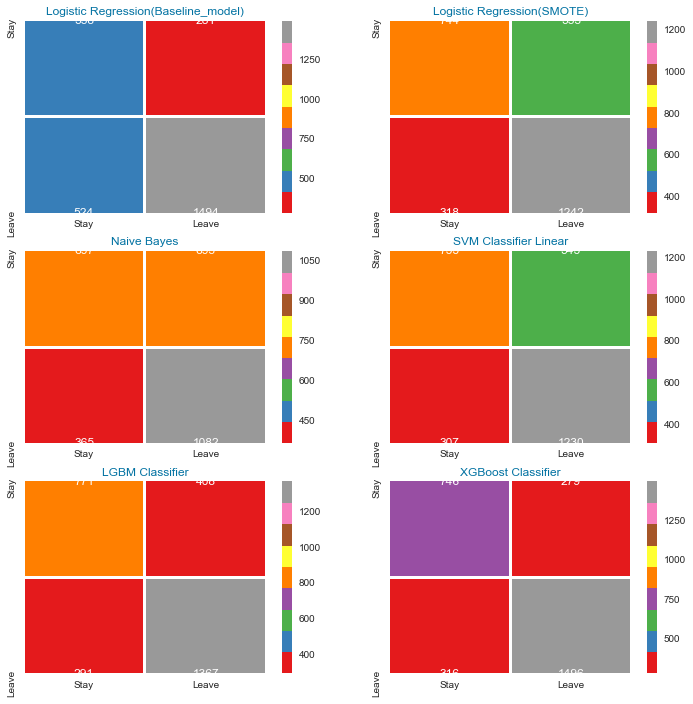

In [27]:
lst    = [logit,logit_smote, gnb, svc_lin,lgbm_c,xgc]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(SMOTE)',
          "Naive Bayes", 'SVM Classifier Linear', 'LGBM Classifier', 'XGBoost Classifier']

fig = plt.figure(figsize=(12,12))
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(3,2,j+1)
    predictions = i.predict(test_X)
    conf_matrix = confusion_matrix(predictions,test_Y)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = False,
                xticklabels=["Stay","Leave"],
                yticklabels=["Stay","Leave"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")

#### 5.4. ROC - Curves for models

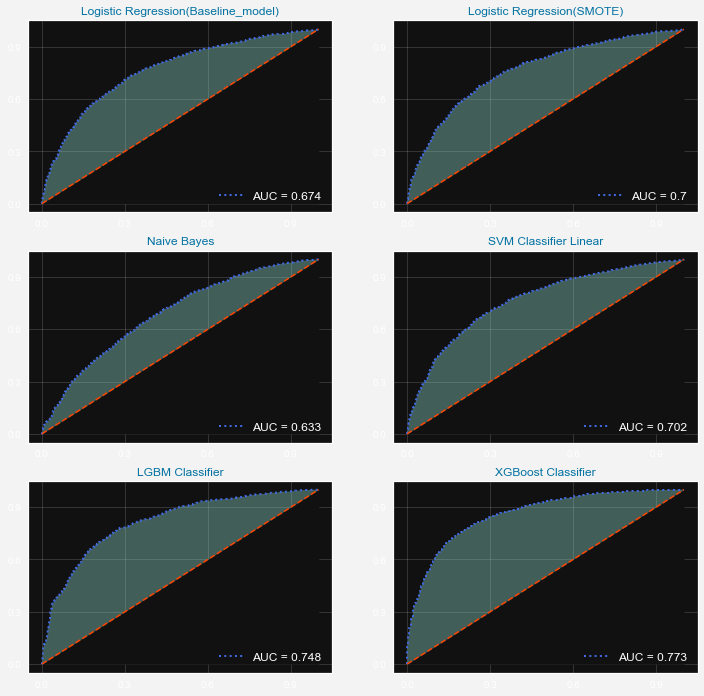

In [28]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(12,12))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    qx = plt.subplot(3,2,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(test_Y,predictions),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

### 6. Discussion

#### 6.1. Algorithm Selection - LGBM Classifier

As we can see, LGBM Classifier and XGBoost Classifier got almsot equal performance. LGBM managed to get a slightlty better AUC = 0.775. Another interesting point, the number of FN predicted by XGBoost and LGBM are almsot equal. This is an important criterion since in the hypothesis that I will suggest later I will focus on customers leaving. Since LGBM was faster and got a better scores I will suggest to use this algorithm.


#### 6.2. Features having the most impact on a customer leaving

After I have selected the best model, I have also find out which features have the most impact on a customer leaving. Therefore it is highly recommended to share these insights with your customer success team and adapt their focus. Only if the team knows where to put emphasis on, the team is able to to guide a customer to features that make him/her stick around longer. 

<img src="images\image.png">

### 7. Test Dataset

In [29]:
df_test = pd.read_csv('validation.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Data columns (total 18 columns):
CUSTOMER_ID                    3993 non-null object
COLLEGE                        3993 non-null object
DATA                           3993 non-null float64
INCOME                         3993 non-null float64
OVERCHARGE                     3993 non-null int64
LEFTOVER                       3993 non-null int64
HOUSE                          3794 non-null float64
LESSTHAN600k                   3794 non-null object
CHILD                          3993 non-null int64
JOB_CLASS                      3993 non-null int64
REVENUE                        3993 non-null float64
HANDSET_PRICE                  3993 non-null int64
OVER_15MINS_CALLS_PER_MONTH    3993 non-null int64
TIME_CLIENT                    3993 non-null float64
AVERAGE_CALL_DURATION          3993 non-null int64
REPORTED_SATISFACTION          3993 non-null object
REPORTED_USAGE_LEVEL           3993 non-null object
CONSIDERING

In [30]:
#Dropping LESSTHAN600K & CUSTOMER_ID
df_test = df_test.drop(labels=['LESSTHAN600k'], axis=1)
df_test = df_test.drop(labels=['CUSTOMER_ID'], axis=1)

#Separating catagorical and numerical columns
#constumer id column
Id_col_test     = ['CUSTOMER_ID']
#target column
target_col_test = ["CHURNED"]
#categorical columns
cat_cols_test   = df_test.nunique()[df_test.nunique() < 6].keys().tolist()
cat_cols_test   = [x for x in cat_cols_test if x not in target_col_test]
#numerical columns
num_cols_test   = [x for x in df_test.columns if x not in cat_cols_test + target_col_test + Id_col_test]
#Binary columns with 2 values
bin_cols_test   = df_test.nunique()[df_test.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols_test = [i for i in cat_cols_test if i not in bin_cols_test]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols_test :
    df_test[i] = le.fit_transform(df_test[i])
    
#Duplicating columns for multi value columns
df_test = pd.get_dummies(data = df_test,columns = multi_cols_test )

#Copying original table beforing standarisation
df_og_test = df_test.copy()

#Scaling Numerical columns
std = StandardScaler()
df_test[num_cols_test] = std.fit_transform(df_test[num_cols_test])

In [31]:
#Predict Churn and churn probability
predictions_test   = lgbm_c.predict(df_test)
probabilities_test = lgbm_c.predict_proba(df_test)

predictions_test=predictions_test.reshape(-1,1)
probabilities_test = probabilities_test.reshape(-1,2)
predictions_test.shape, probabilities_test.shape

#Create dataframe with predictions
p     = pd.DataFrame(predictions_test)
q     = pd.DataFrame(probabilities_test)
pred_    = pd.merge(p,q,left_index= True, right_index= True, how = "left")
pred_.columns = ["CHURN_LABEL","CHURN_PROBABILITY", "NOT_CHURN_PROBABILITY"]

#Replace values in CHURN_LABEL with the suggested ones
pred_.CHURN_LABEL = pred_.CHURN_LABEL.astype(str)
pred_['CHURN_LABEL'] = pred_['CHURN_LABEL'].replace(['1'], 'STAY')
pred_['CHURN_LABEL'] = pred_['CHURN_LABEL'].replace(['0'], 'LEAVE')

#Add predictions in test dataset dataframe
df_test = pd.read_csv('validation.csv')
df_test = pd.merge(pd.merge(df_test, pred_['CHURN_LABEL'],
                   left_index= True, right_index= True, how = "left"),
                   pred_['CHURN_PROBABILITY'],
                   left_index= True, right_index= True, how = "left")

#Add CLIENT_TO_CONTACT column
conditions = [
    (df_test['CHURN_PROBABILITY'] > 0.55) & (df_test['CHURN_LABEL'] == "LEAVE")]
choices = ['YES']
df_test['CLIENT_TO_CONTACT'] = np.select(conditions, choices, default='NO')

In [32]:
#Total revenue ratio per client by category

more_90 = (df_test['CHURN_PROBABILITY'] > 0.9)
df_90 = df_test[more_90]
e = (df_90['REVENUE'].sum() + df_90['OVERCHARGE'].sum())/len(df_90)

more_80 = (df_test['CHURN_PROBABILITY'] < 0.9) & (df_test['CHURN_PROBABILITY'] >= 0.8)
df_80 = df_test[more_80]
a = (df_80['REVENUE'].sum() + df_80['OVERCHARGE'].sum())/len(df_80)

more_70 = (df_test['CHURN_PROBABILITY'] < 0.8) & (df_test['CHURN_PROBABILITY'] >= 0.7)
df_70 = df_test[more_70]
b = (df_70['REVENUE'].sum() + df_70['OVERCHARGE'].sum())/len(df_70)

more_60 = (df_test['CHURN_PROBABILITY'] < 0.7) & (df_test['CHURN_PROBABILITY'] >= 0.6)
df_60 = df_test[more_60]
c = (df_60['REVENUE'].sum() + df_60['OVERCHARGE'].sum())/len(df_60)

more_50 = (df_test['CHURN_PROBABILITY'] < 0.6) & (df_test['CHURN_PROBABILITY'] > 0.5)
df_50 = df_test[more_50]
d = (df_50['REVENUE'].sum() + df_50['OVERCHARGE'].sum())/len(df_50)

more_50 = (df_test['CHURN_PROBABILITY'] < 0.55) & (df_test['CHURN_LABEL'] == "LEAVE")
df_50 = df_test[more_50]
f = (df_50['REVENUE'].sum() + df_50['OVERCHARGE'].sum())/len(df_50)

print(e,a,b,c,d,f)

nan nan 346.11989100817436 255.5551425030979 213.56899004267424 213.61878453038673


###### Acquiring new customers is neither easy, nor cheap, and it would sound reasonable to take care of the clients that they have.
###### Except customers with CHURN_PROBABILITY less than 0.55 (knowing that the contact price per customer is 10 I want to be sure that the costs of the retention program do not outweigh the profits to be gained from the customers I intend to save, because clients in this category generate a cumulative revenue ratio equal to 224), I am suggesting to contact all predicted leaving clients even customers having a churn probability greater than 0.9 (I think that in this case it is better that the provider must know his clients’ needs and be able to answer these needs – neither by adjusting their offer nor by changing the way they approach the client. a Possible analytic solution could be clients segmentation based on the provided data).

###### Customers with a proba greater than 0.9 have the highest revenue ratio. So I propose to offer them the most interesting discount (1 year subscription at 50%, i.e. 50% of the REVENUE, excluding overcharge). Then those with churn proba = 0.8 and so on.  

In [33]:
conditions = [
    (df_test['CHURN_PROBABILITY'] > 0.9),
    (df_test['CHURN_PROBABILITY'] < 0.9) & (df_test['CHURN_PROBABILITY'] >= 0.8),
    (df_test['CHURN_PROBABILITY'] < 0.8) & (df_test['CHURN_PROBABILITY'] >= 0.7),
    (df_test['CHURN_PROBABILITY'] < 0.7) & (df_test['CHURN_PROBABILITY'] >= 0.6),
    (df_test['CHURN_PROBABILITY'] < 0.6) & (df_test['CHURN_PROBABILITY'] >= 0.55)
]

#0.5  = 50% discount for 1 year
#0.25 = 50% discount for 6 months
#0.17  = 50% discount for 4 months
#0.125  = 50% discount for 3 months
#0.042  = 50% discount for 1 month
choices = [0.5, 0.25, 0.17, 0.125, 0.042]

df_test['DISCOUNT'] = np.select(conditions, choices, default=0)
df_test['DISCOUNT'] = df_test['DISCOUNT']*df_test['REVENUE']

In [34]:
print("Client to contact total revenue: \n", 
      df_test.loc[df_test['CLIENT_TO_CONTACT'] == "YES", ['REVENUE','OVERCHARGE']].sum(),
      "\n",
     "Total Discount outcome: \n", df_test['DISCOUNT'].sum())

Client to contact total revenue: 
 REVENUE       234114.0
OVERCHARGE    171954.0
dtype: float64 
 Total Discount outcome: 
 27406.992


###### With the provided data the costs of my retention program do not outweigh the profits to be gained from the customers I intend to save.

##### Submission file

In [35]:
submission =  df_test[['CUSTOMER_ID','CHURN_LABEL', 'CHURN_PROBABILITY', 'CLIENT_TO_CONTACT', 'DISCOUNT']]
export_csv = submission.to_csv (r'submission.csv', index = None, header=True)